In [1]:
!pip install --quiet huggingface_hub

In [4]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
from collections import Counter
import huggingface_hub
import os
import warnings
import time

In [5]:
# Login is optional for public models
# huggingface_hub.login()

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Ignore warning to create a token
    corpus_file_path = huggingface_hub.hf_hub_download(
        repo_id="ardMLX/text8",
        filename="text8",
        repo_type="dataset",
        local_dir="."
    )

print(f"File downloaded to: {corpus_file_path}")

File downloaded to: text8


In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: mps


In [8]:
def tokenize(text):
    return text.lower().split()

# TODO Use torchtext.vocab.build_vocab_from_iterator
def build_vocab(tokens, min_freq=1):
    counter = Counter(tokens)
    vocab = {word: idx for idx, (word, freq) in enumerate(counter.items()) if freq >= min_freq}
    word2idx = {word: i for i, word in enumerate(vocab)}
    idx2word = {i: word for word, i in word2idx.items()}
    return word2idx, idx2word

## CBOW

In [9]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # TODO Do we have to do max norm here?
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, max_norm=1.0)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        x = self.embeddings(inputs)
        x = x.mean(dim=1)
        x = self.linear(x)
        return x

In [10]:
class CBOWDataset(Dataset):
    def __init__(self, tokens, word2idx, context_size=2):
        self.data = []
        self.word2idx = word2idx
        self.context_size = context_size
        self.vocab_size = len(word2idx)

        indices = [word2idx[word] for word in tokens if word in word2idx]
        # TODO add tqdm progress
        for i in range(context_size, len(indices) - context_size):
            context = (
                indices[i - context_size:i] + indices[i + 1:i + context_size + 1]
            )
            target = indices[i]
            self.data.append((context, target))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target = self.data[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

In [11]:
def print_closest_words(model, word2idx, idx2word, words, device, top_k=5):
    embeddings = model.embeddings.weight.data
    norm = embeddings / embeddings.norm(dim=1, keepdim=True)
    for word in words:
        if word not in word2idx:
            print(f"{word}: not in vocabulary")
            continue
        idx = word2idx[word]
        query = norm[idx]
        similarities = torch.matmul(norm, query)
        nearest = similarities.topk(top_k + 1).indices[1:]  # exclude self
        nearest_words = [idx2word[i.item()] for i in nearest]
        print(f"{word}: {', '.join(nearest_words)}")

In [12]:
def train_model(model, dataloader, num_epochs, lr, device):
    model.to(device)
    # TODO Use torch.optim.lr_scheduler to decay learning rate
    # TODO See how nn.CrossEntropyLoss is implemented
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        total_loss = 0
        for i, (context, target) in enumerate(dataloader):
            context, target = context.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(context)
            loss = criterion(output, target)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            if i % 1000 == 0:
                print(f"Time: {time.strftime('%Y-%m-%d %H:%M:%S')}, Epoch {epoch+1}, Step {i}, Loss: {loss.item():.4f}")
            if i % 10000 == 0:
                print("\nClosest words to some test words:")
                eval_words = ["king", "man", "woman", "computer", "music"]
                print_closest_words(model, word2idx, idx2word, eval_words, device, top_k=5)

                snapshot_path = f"cbow_epoch{epoch+1}_step{i}.pt"
                torch.save(model.state_dict(), snapshot_path)
                print(f"Model snapshot saved to {snapshot_path}")


In [13]:
# Load and process text
with open(corpus_file_path, "r") as f:
    tokens = tokenize(f.read())

# Build vocab
word2idx, idx2word = build_vocab(tokens, min_freq=1)

# Create dataset and dataloader
context_size = 2
dataset = CBOWDataset(tokens, word2idx, context_size=context_size)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
len(word2idx)

253854

In [15]:
len(dataset)

17005203

In [16]:
len(dataloader)

531413

In [17]:
# Create model and train
vocab_size = len(word2idx)
embedding_dim = 100
model = CBOW(vocab_size, embedding_dim)
print(model)

CBOW(
  (embeddings): Embedding(253854, 100, max_norm=1.0)
  (linear): Linear(in_features=100, out_features=253854, bias=True)
)


In [ ]:
train_model(model, dataloader, num_epochs=1, lr=0.001, device=device)

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/functional.py:2434: UserWarning: The operator 'aten::embedding_renorm_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:14.)
  torch.embedding_renorm_(weight.detach(), input, max_norm, norm_type)


Time: 2025-06-11 14:04:12, Epoch 1, Step 0, Loss: 12.4774

Closest words to some test words:
king: rber, abu, gaber, katzenjammer, vater
man: salafist, docherty, nemausus, ogili, aymer
woman: senat, morgul, austrinus, moonwalkers, ramjets
computer: majed, ebooks, tsom, dho, hybrid
music: pathe, vascularity, banuera, topi, failghe
Model snapshot saved to cbow_epoch1_step0.pt
Time: 2025-06-11 14:06:26, Epoch 1, Step 1000, Loss: 9.0032
Time: 2025-06-11 14:08:34, Epoch 1, Step 2000, Loss: 6.9895
Time: 2025-06-11 14:10:53, Epoch 1, Step 3000, Loss: 9.1863
Time: 2025-06-11 14:13:10, Epoch 1, Step 4000, Loss: 7.8078
Time: 2025-06-11 14:15:26, Epoch 1, Step 5000, Loss: 8.0979
Time: 2025-06-11 14:17:43, Epoch 1, Step 6000, Loss: 7.3938
Time: 2025-06-11 14:20:11, Epoch 1, Step 7000, Loss: 7.3737
Time: 2025-06-11 14:22:39, Epoch 1, Step 8000, Loss: 7.5670
Time: 2025-06-11 14:25:21, Epoch 1, Step 9000, Loss: 8.7345
Time: 2025-06-11 14:28:46, Epoch 1, Step 10000, Loss: 7.2708

Closest words to some

In [ ]:
torch.save(model.state_dict(), f"cbow_final.pt")

In [20]:
model.load_state_dict(torch.load("cbow_final.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

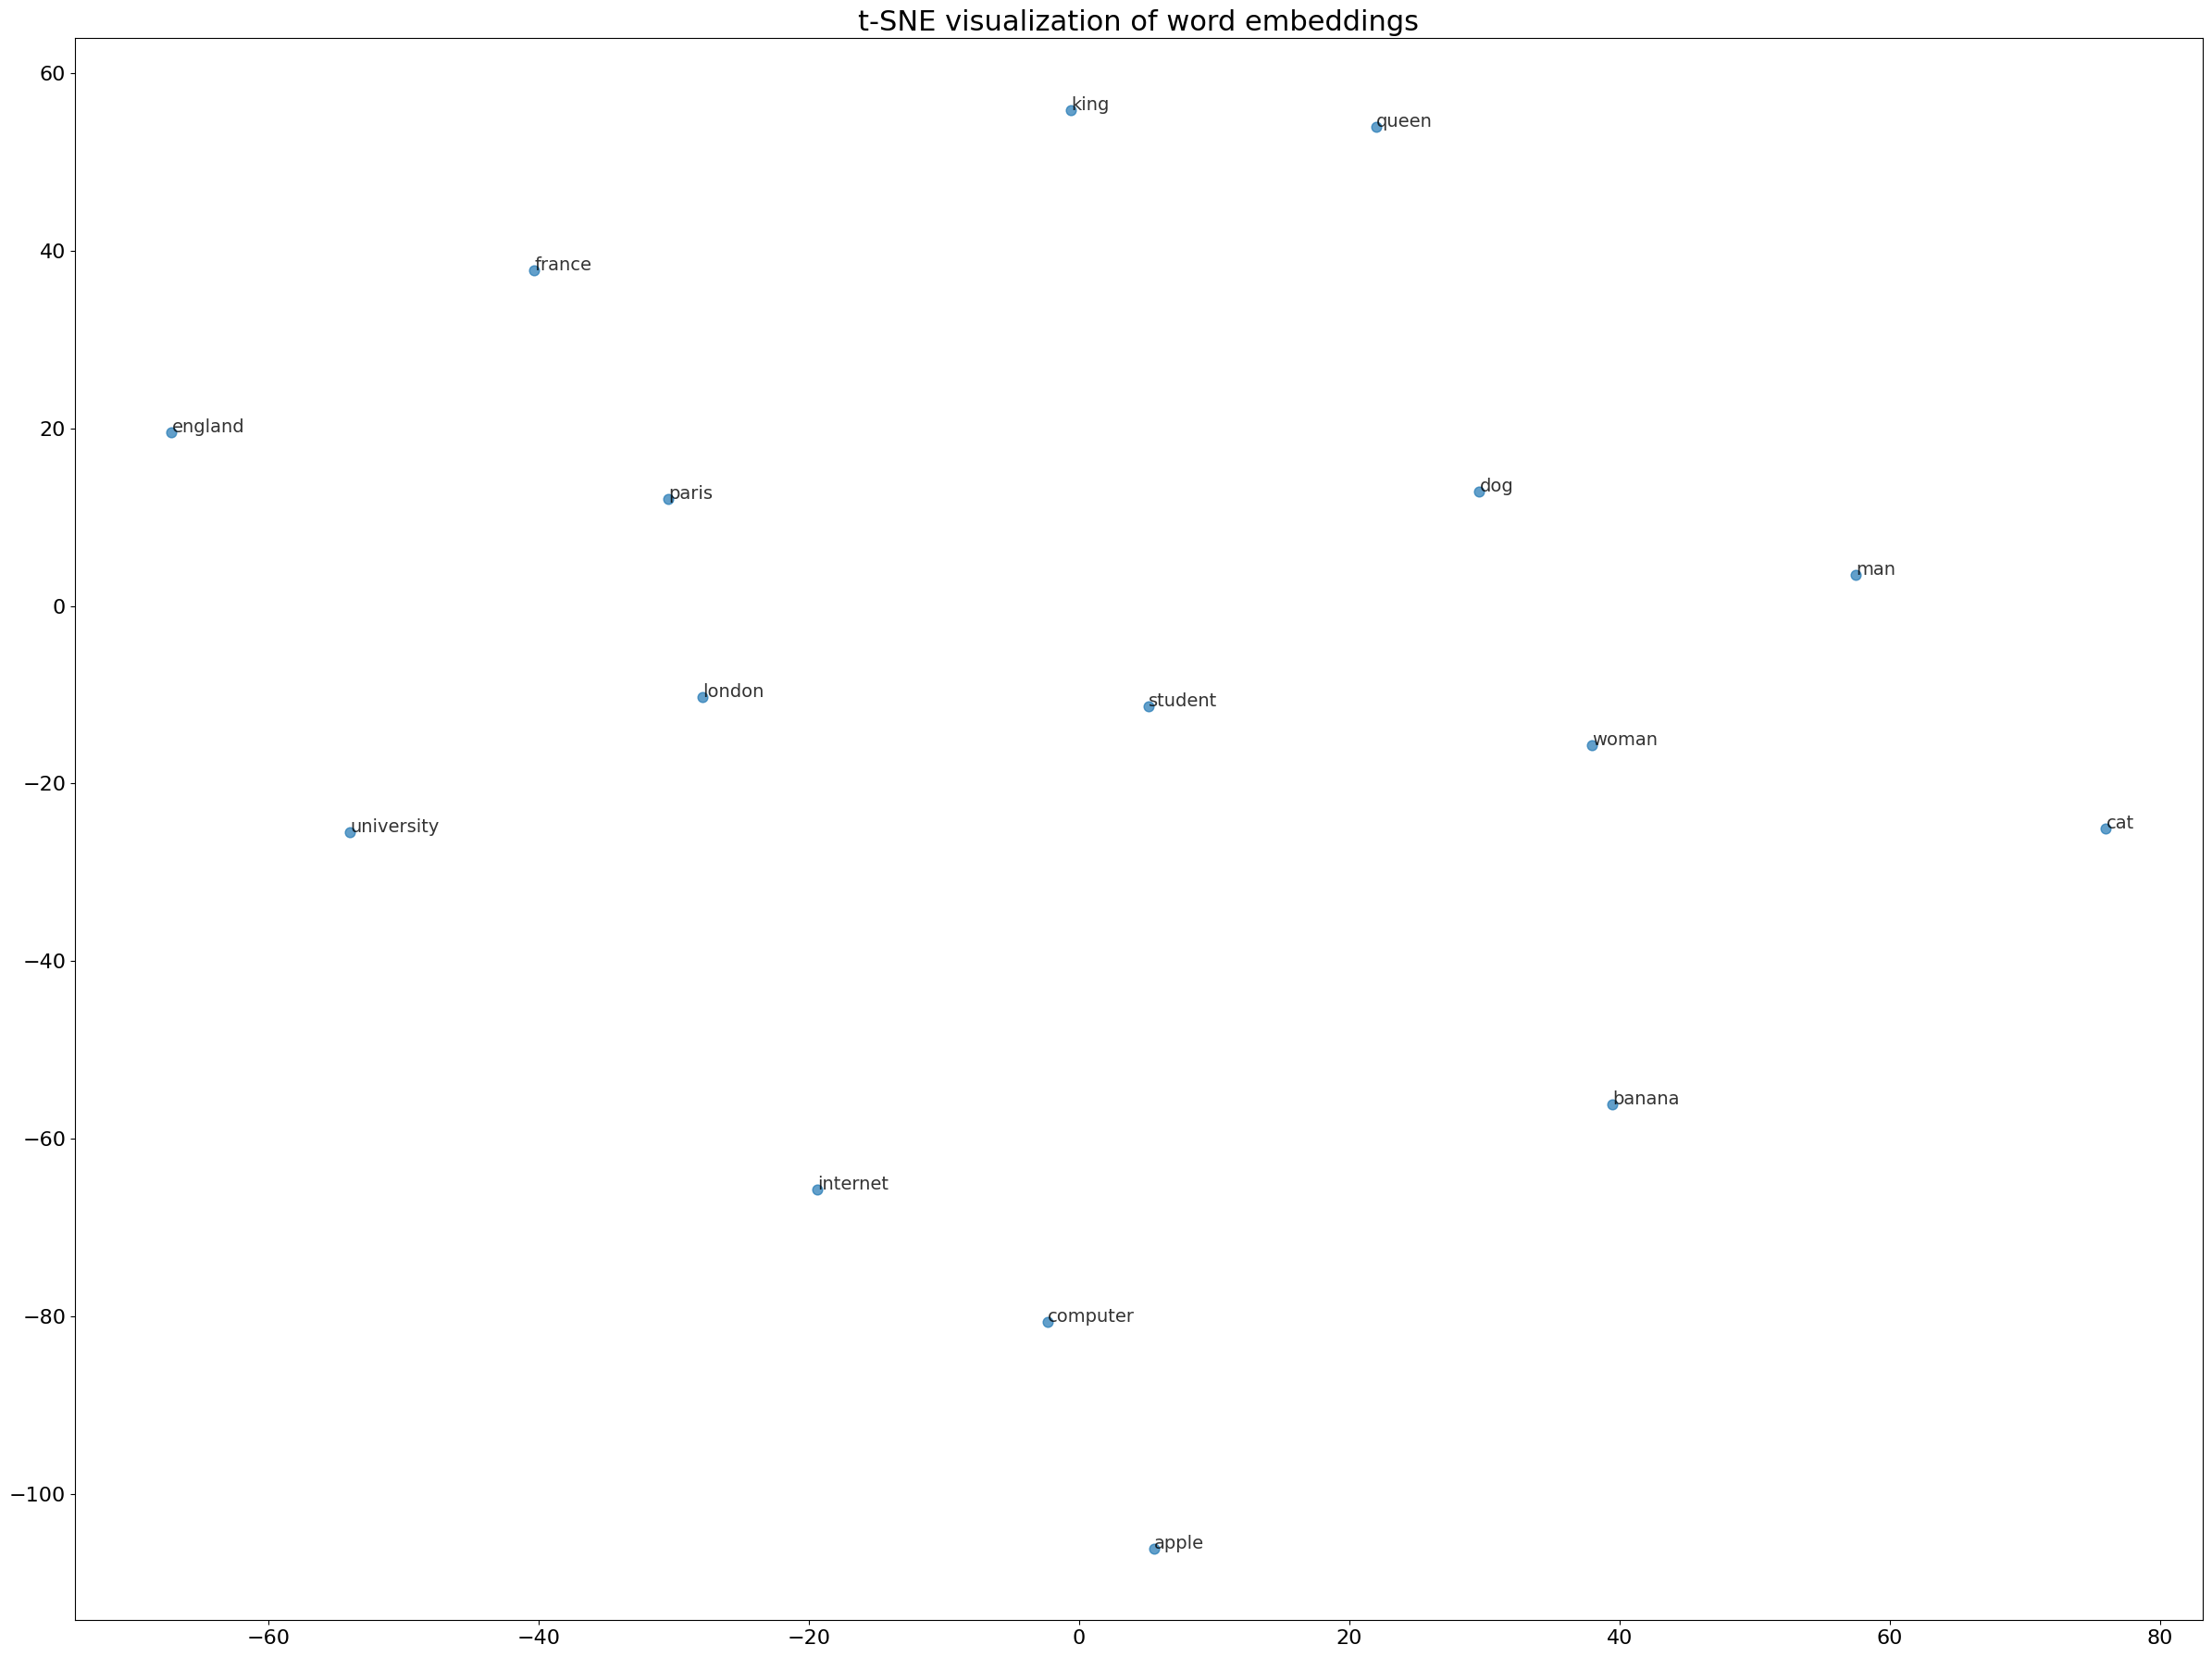

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

import matplotlib.pyplot as plt

# Sample a subset of words for visualization
# Randomly sample 100 words from the vocabulary for visualization
# np.random.seed(42)
# sample_words = np.random.choice(list(word2idx.keys()), size=200, replace=False)
animals = ["cat", "dog", "horse", "cow", "lion"]
countries = ["france", "germany", "china", "india", "brazil"]
fruits = ["apple", "banana", "grape", "orange", "mango"]
sample_words = animals + countries + fruits

sample_words = ["king", "queen", "man", "woman", "paris", "france", "london", "england",
                "apple", "banana", "cat", "dog", "computer", "internet", "university", "student"]

# Get embeddings for the sample words
embeddings = model.embeddings.weight.data.cpu().numpy()
indices = [word2idx[w] for w in sample_words]
sample_embeds = embeddings[indices]

# PCA + t-SNE
pca = PCA(n_components=min(15, sample_embeds.shape[0]), random_state=42)
reduced = pca.fit_transform(sample_embeds)

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, sample_embeds.shape[0] / 2), init='pca')
embeds_2d = tsne.fit_transform(reduced)

# Plot with larger figure and improved readability
plt.figure(figsize=(24, 18))
plt.scatter(embeds_2d[:, 0], embeds_2d[:, 1], s=60, alpha=0.7)
for i, word in enumerate(sample_words):
    plt.annotate(word, (embeds_2d[i, 0], embeds_2d[i, 1]), fontsize=14, alpha=0.8)
plt.title("t-SNE visualization of word embeddings", fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()